# Finding Similar Songs - Part 1: Distance Based Search

The first part of this tutorial series demonstrates a distance based similarity search approach, based on extracted content descriptors and distance metrics. 

## Music Similarity Retrieval

The objective of Music Similarity estimation or retrieval is to estimate the notion of similarity between two given tracks. A central part of such an approach is the definition of a measure for similarity which is further affected by the approach taken to extract the relevant information. 

The approach followed by this tutorial is based on the music content itself and largely focuses on the notion of **acoustic similarity**. Music features are extracted from the audio content. The resulting music descriptors are high-dimensional numeric vectors and the accumulation of all feature vectors of a collection forms a vector-space. 

The general principle of **content based similarity estimations** is based on the assumption that numerical differences are an expression of perceptual dissimilarity. Different metrics such as the *Manhattan* (L1) or the *Euclidean Distance* (L2) or non-metric similarity functions such as the *Kullback-Leibler* divergence are used to estimate the numerical similarity of the feature vectors.

## Requirements

In [381]:
# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns

# numeric and scientific processing
import numpy as np
import pandas as pd

# misc
import os
import progressbar

from IPython.display import HTML, display
pd.set_option('display.max_colwidth', -1)

<ipython-input-381-ce484a3be253>:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Loading Data

Download and extract the dataset on `SPECTROGRAM_PATH`. 

In [382]:
DATASET_PATH = '../../../Machine-Learning/ismir2018'
METADATA_PATH = '../../../Machine-Learning/ismir2018/metadata'
AUDIO_PATH = '../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset'

DATASET_FILE = os.path.join(DATASET_PATH,'ISMIR2018_tut_Magnagtagatune_rp_features.npz')
METADATA_FILE = os.path.join(METADATA_PATH,'ismir2018_tut_part_1_genres_metadata_subset.csv') 
LABEL_FILE = os.path.join(METADATA_PATH,'ismir2018_tut_part_2_similarity_labels_subset.csv')

### Load Feature Data

We load these from a Numpy .npz file, which contains the features and also the associated clip ids:

In [383]:
npz = np.load(DATASET_FILE)
features_rp = npz['rp']
features_ssd = npz['ssd']
features_clip_id = npz['clip_id']

# check how many features we have and their dimensions
features_rp.shape

(1998, 1440)

In [384]:
# check whether we have the same number of clip ids
len(features_clip_id)

1998

In [385]:
# create a dataframe that associates the index order of the features with the clip ids
feature_metadata = pd.DataFrame({'featurespace_id':np.arange(features_rp.shape[0]),
                                 'clip_id'        :features_clip_id})

# dataframe
feature_metadata

,featurespace_id,clip_id
0,0,41797
1,1,38338
2,2,34335
3,3,25542
4,4,38344
...,...,...
1993,1993,29845
1994,1994,20711
1995,1995,5644
1996,1996,34175


### Load Metadata

In [386]:
metadata = pd.read_csv(METADATA_FILE, index_col=0)
metadata.shape

(1998, 10)

In [387]:
# dataframe
metadata

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url
19072,41797,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3,10,(I wanna) beer sandwich,Jackalopes,Jacksploitation,http://www.magnatune.com/artists/albums/jackalopes-jacksploit/,59,88,http://he3.magnatune.com/all/10-(I%20wanna)%20beer%20sandwich-Jackalopes.mp3
17487,38338,D:/Research/Data/MIR/MagnaTagATune/mp3_full/6/ralph_meulenbroeks-gambomania-09-a_question_tobias_hume-59-88.mp3,9,-A Question (Tobias Hume)-,Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulenbroeks-gambomania/,59,88,http://he3.magnatune.com/all/09--A%20Question%20(Tobias%20Hume)--Ralph%20Meulenbroeks.mp3
15668,34335,D:/Research/Data/MIR/MagnaTagATune/mp3_full/0/rocket_city_riot-last_of_the_pleasure_seekers-08-all_i_got-30-59.mp3,8,-All I Got-,Rocket City Riot,Last Of The Pleasure Seekers,http://www.magnatune.com/artists/albums/rocketcity-pleasure/,30,59,http://he3.magnatune.com/all/08--All%20I%20Got--Rocket%20City%20Riot.mp3
11610,25542,D:/Research/Data/MIR/MagnaTagATune/mp3_full/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-06-annes_decision-59-88.mp3,6,-Anne's Decision-,Philharmonia Baroque Orchestra,Jake Heggie - To Hell and Back,http://www.magnatune.com/artists/albums/pb-heggie/,59,88,http://he3.magnatune.com/all/06--Anne's%20Decision--Philharmonia%20Baroque%20Orchestra.mp3
17489,38344,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/the_headroom_project-jetuton_andawai-09-anu_de_dilaho-88-117.mp3,9,-Anu de Dilaho-,The Headroom Project,Jetuton Andawai,http://www.magnatune.com/artists/albums/headroom-jetuton/,88,117,http://he3.magnatune.com/all/09--Anu%20de%20Dilaho--The%20Headroom%20Project.mp3
...,...,...,...,...,...,...,...,...,...,...
13597,29845,D:/Research/Data/MIR/MagnaTagATune/mp3_full/4/music_of_the_spheres-music_of_the_spheres-06-von_biber_passacaglia_for_solo_violins-30-59.mp3,6,von Biber_ Passacaglia for solo violins,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/06-von%20Biber_%20Passacaglia%20for%20solo%20violins-Music%20of%20the%20Spheres.mp3
9433,20711,D:/Research/Data/MIR/MagnaTagATune/mp3_full/4/music_of_the_spheres-music_of_the_spheres-04-von_biber_sonata_i_in_a_major-30-59.mp3,4,von Biber_ Sonata I in A Major,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/04-von%20Biber_%20Sonata%20I%20in%20A%20Major-Music%20of%20the%20Spheres.mp3
2579,5644,D:/Research/Data/MIR/MagnaTagATune/mp3_full/6/drop_trio-cezanne-01-wallawalla-117-146.mp3,1,wallawalla,Drop Trio,Cezanne,http://www.magnatune.com/artists/albums/droptrio-cezanne/,117,146,http://he3.magnatune.com/all/01-wallawalla-Drop%20Trio.mp3
15587,34175,D:/Research/Data/MIR/MagnaTagATune/mp3_full/a/mr_gelatine-electroluv-07-wallguitar-30-59.mp3,7,wallguitar,Mr Gelatine,Electroluv,http://www.magnatune.com/artists/albums/gelatine-electroluv/,30,59,http://he3.magnatune.com/all/07-wallguitar-Mr%20Gelatine.mp3


#### Change filename of Metadata

In [388]:
raiz_old = 'D:/Research/Data/MIR/MagnaTagATune'
raiz_new = AUDIO_PATH
i = -1

for fn in metadata.mp3_path:
    fn_new = fn.replace(raiz_old,raiz_new)
    i = i+1
    metadata.iloc[i,1] = fn_new
    #metadata.mp3_path.iloc[i] = fn_new # tira WARNING
    
metadata

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url
19072,41797,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3,10,(I wanna) beer sandwich,Jackalopes,Jacksploitation,http://www.magnatune.com/artists/albums/jackalopes-jacksploit/,59,88,http://he3.magnatune.com/all/10-(I%20wanna)%20beer%20sandwich-Jackalopes.mp3
17487,38338,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/ralph_meulenbroeks-gambomania-09-a_question_tobias_hume-59-88.mp3,9,-A Question (Tobias Hume)-,Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulenbroeks-gambomania/,59,88,http://he3.magnatune.com/all/09--A%20Question%20(Tobias%20Hume)--Ralph%20Meulenbroeks.mp3
15668,34335,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/0/rocket_city_riot-last_of_the_pleasure_seekers-08-all_i_got-30-59.mp3,8,-All I Got-,Rocket City Riot,Last Of The Pleasure Seekers,http://www.magnatune.com/artists/albums/rocketcity-pleasure/,30,59,http://he3.magnatune.com/all/08--All%20I%20Got--Rocket%20City%20Riot.mp3
11610,25542,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-06-annes_decision-59-88.mp3,6,-Anne's Decision-,Philharmonia Baroque Orchestra,Jake Heggie - To Hell and Back,http://www.magnatune.com/artists/albums/pb-heggie/,59,88,http://he3.magnatune.com/all/06--Anne's%20Decision--Philharmonia%20Baroque%20Orchestra.mp3
17489,38344,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/the_headroom_project-jetuton_andawai-09-anu_de_dilaho-88-117.mp3,9,-Anu de Dilaho-,The Headroom Project,Jetuton Andawai,http://www.magnatune.com/artists/albums/headroom-jetuton/,88,117,http://he3.magnatune.com/all/09--Anu%20de%20Dilaho--The%20Headroom%20Project.mp3
...,...,...,...,...,...,...,...,...,...,...
13597,29845,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-06-von_biber_passacaglia_for_solo_violins-30-59.mp3,6,von Biber_ Passacaglia for solo violins,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/06-von%20Biber_%20Passacaglia%20for%20solo%20violins-Music%20of%20the%20Spheres.mp3
9433,20711,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-04-von_biber_sonata_i_in_a_major-30-59.mp3,4,von Biber_ Sonata I in A Major,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/04-von%20Biber_%20Sonata%20I%20in%20A%20Major-Music%20of%20the%20Spheres.mp3
2579,5644,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/drop_trio-cezanne-01-wallawalla-117-146.mp3,1,wallawalla,Drop Trio,Cezanne,http://www.magnatune.com/artists/albums/droptrio-cezanne/,117,146,http://he3.magnatune.com/all/01-wallawalla-Drop%20Trio.mp3
15587,34175,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/a/mr_gelatine-electroluv-07-wallguitar-30-59.mp3,7,wallguitar,Mr Gelatine,Electroluv,http://www.magnatune.com/artists/albums/gelatine-electroluv/,30,59,http://he3.magnatune.com/all/07-wallguitar-Mr%20Gelatine.mp3


#### Check if files exist

In [389]:
file_exist_mask = [os.path.exists(fn) for fn in metadata.mp3_path]
np.sum(file_exist_mask)

1998

### Load Label Data

In [390]:
label_metadata = pd.read_csv(LABEL_FILE, index_col=0)
label_metadata.shape

(1998, 133)

In [391]:
# dataframe
label_metadata

,duet,plucking,world,bongos,sitar,chorus,clarinet,woodwind,funky,no strings,...,opera,orchestra,quiet,singer,space,string,synth,violin,vocal,strange
19072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11610,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
17489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
9433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [392]:
# how many tracks per Tag
label_metadata.sum()

duet        9  
plucking    6  
world       1  
bongos      2  
sitar       13 
            .. 
string      402
synth       133
violin      285
vocal       229
strange     46 
Length: 133, dtype: int64

In [393]:
# number of Tags per track
label_metadata.sum(axis=1)

19072    1
17487    4
15668    4
11610    4
17489    2
        ..
13597    6
9433     5
2579     3
15587    3
19000    2
Length: 1998, dtype: int64

### Inspect Metadata

**Plot most frequent Tags**

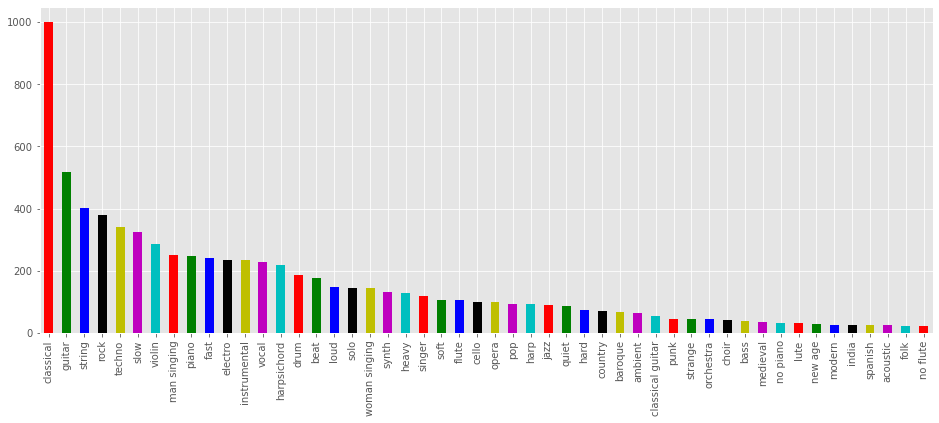

In [394]:
my_colors = list('rgbkymc') # red, green, blue, black, etc.
label_metadata.sum(axis=0).sort_values(ascending=False)[:50].plot(kind='bar', color=my_colors, figsize=(16,6));

**Plot Co-occurrences**

* Sorted by most frequent labels
* Shows most frequent labels and how they co-occurr
* Visualization to get an overview of Tag frequencies

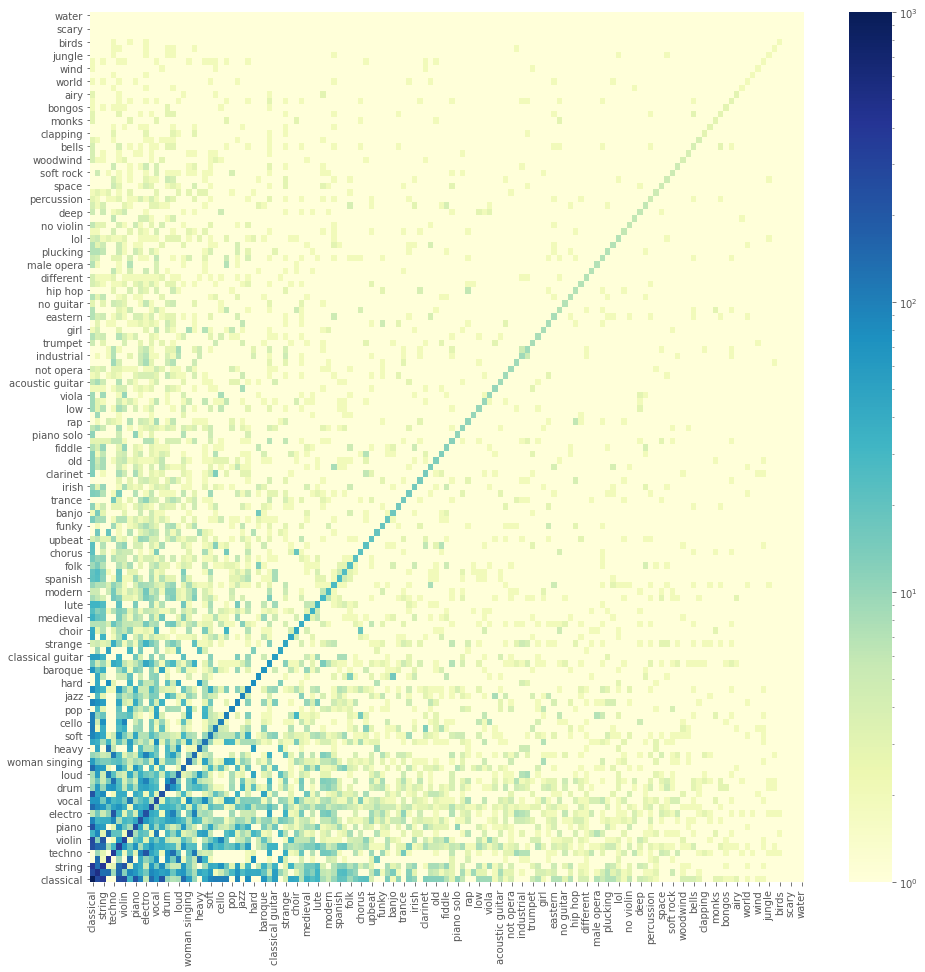

In [395]:
# calculate co-occurencies
coorc = label_metadata.T.dot(label_metadata)

# sort co-occurrence matrix
coorc = coorc.loc[coorc.max().sort_values(ascending=False).index]
coorc = coorc[coorc.max().sort_values(ascending=False).index]

# scale heat-map color encoding logarithmically
from matplotlib.colors import LogNorm

# shift by one to avoid log-domain error
coorc += 1

vmin = coorc.min().min()
vmax = coorc.max().max()

log_norm   = LogNorm(vmin=vmin, vmax=vmax)
cbar_ticks = [np.power(10, i) for i in np.arange(np.floor(np.log10(vmin)), 1+np.ceil(np.log10(vmax)))]

# plot
fig = plt.figure(figsize=(16,16))
ax = sns.heatmap(coorc, annot=False, cmap="YlGnBu", fmt='g', norm=log_norm, cbar_kws={"ticks": cbar_ticks});
ax.invert_yaxis()

### Align Metadata and Features

In [396]:
metadata = metadata.reset_index()
metadata = metadata.merge(feature_metadata, left_on='clip_id', right_on='clip_id', how='inner', left_index=True, right_index=False)
metadata = metadata.set_index('index')
metadata

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url,featurespace_id
index,,,,,,,,,,,
19072,41797,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3,10,(I wanna) beer sandwich,Jackalopes,Jacksploitation,http://www.magnatune.com/artists/albums/jackalopes-jacksploit/,59,88,http://he3.magnatune.com/all/10-(I%20wanna)%20beer%20sandwich-Jackalopes.mp3,0
17487,38338,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/ralph_meulenbroeks-gambomania-09-a_question_tobias_hume-59-88.mp3,9,-A Question (Tobias Hume)-,Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulenbroeks-gambomania/,59,88,http://he3.magnatune.com/all/09--A%20Question%20(Tobias%20Hume)--Ralph%20Meulenbroeks.mp3,1
15668,34335,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/0/rocket_city_riot-last_of_the_pleasure_seekers-08-all_i_got-30-59.mp3,8,-All I Got-,Rocket City Riot,Last Of The Pleasure Seekers,http://www.magnatune.com/artists/albums/rocketcity-pleasure/,30,59,http://he3.magnatune.com/all/08--All%20I%20Got--Rocket%20City%20Riot.mp3,2
11610,25542,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-06-annes_decision-59-88.mp3,6,-Anne's Decision-,Philharmonia Baroque Orchestra,Jake Heggie - To Hell and Back,http://www.magnatune.com/artists/albums/pb-heggie/,59,88,http://he3.magnatune.com/all/06--Anne's%20Decision--Philharmonia%20Baroque%20Orchestra.mp3,3
17489,38344,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/the_headroom_project-jetuton_andawai-09-anu_de_dilaho-88-117.mp3,9,-Anu de Dilaho-,The Headroom Project,Jetuton Andawai,http://www.magnatune.com/artists/albums/headroom-jetuton/,88,117,http://he3.magnatune.com/all/09--Anu%20de%20Dilaho--The%20Headroom%20Project.mp3,4
...,...,...,...,...,...,...,...,...,...,...,...
13597,29845,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-06-von_biber_passacaglia_for_solo_violins-30-59.mp3,6,von Biber_ Passacaglia for solo violins,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/06-von%20Biber_%20Passacaglia%20for%20solo%20violins-Music%20of%20the%20Spheres.mp3,1993
9433,20711,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-04-von_biber_sonata_i_in_a_major-30-59.mp3,4,von Biber_ Sonata I in A Major,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/04-von%20Biber_%20Sonata%20I%20in%20A%20Major-Music%20of%20the%20Spheres.mp3,1994
2579,5644,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/drop_trio-cezanne-01-wallawalla-117-146.mp3,1,wallawalla,Drop Trio,Cezanne,http://www.magnatune.com/artists/albums/droptrio-cezanne/,117,146,http://he3.magnatune.com/all/01-wallawalla-Drop%20Trio.mp3,1995


### Add Media-Player to Metadata

#### Ejemplo: Integrar Objeto de audio en Jupyter

<audio src="../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3" type="audio/mpeg" controls="controls"></audio>

#### Ahora en los Metadatos!

In [397]:
metadata['player'] = '<audio src="' + metadata.mp3_path + '" type="audio/mpeg" controls="controls"></audio>'
metadata

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url,featurespace_id,player
index,,,,,,,,,,,,
19072,41797,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3,10,(I wanna) beer sandwich,Jackalopes,Jacksploitation,http://www.magnatune.com/artists/albums/jackalopes-jacksploit/,59,88,http://he3.magnatune.com/all/10-(I%20wanna)%20beer%20sandwich-Jackalopes.mp3,0,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
17487,38338,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/ralph_meulenbroeks-gambomania-09-a_question_tobias_hume-59-88.mp3,9,-A Question (Tobias Hume)-,Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulenbroeks-gambomania/,59,88,http://he3.magnatune.com/all/09--A%20Question%20(Tobias%20Hume)--Ralph%20Meulenbroeks.mp3,1,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/ralph_meulenbroeks-gambomania-09-a_question_tobias_hume-59-88.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
15668,34335,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/0/rocket_city_riot-last_of_the_pleasure_seekers-08-all_i_got-30-59.mp3,8,-All I Got-,Rocket City Riot,Last Of The Pleasure Seekers,http://www.magnatune.com/artists/albums/rocketcity-pleasure/,30,59,http://he3.magnatune.com/all/08--All%20I%20Got--Rocket%20City%20Riot.mp3,2,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/0/rocket_city_riot-last_of_the_pleasure_seekers-08-all_i_got-30-59.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
11610,25542,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-06-annes_decision-59-88.mp3,6,-Anne's Decision-,Philharmonia Baroque Orchestra,Jake Heggie - To Hell and Back,http://www.magnatune.com/artists/albums/pb-heggie/,59,88,http://he3.magnatune.com/all/06--Anne's%20Decision--Philharmonia%20Baroque%20Orchestra.mp3,3,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-06-annes_decision-59-88.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
17489,38344,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/the_headroom_project-jetuton_andawai-09-anu_de_dilaho-88-117.mp3,9,-Anu de Dilaho-,The Headroom Project,Jetuton Andawai,http://www.magnatune.com/artists/albums/headroom-jetuton/,88,117,http://he3.magnatune.com/all/09--Anu%20de%20Dilaho--The%20Headroom%20Project.mp3,4,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/the_headroom_project-jetuton_andawai-09-anu_de_dilaho-88-117.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
...,...,...,...,...,...,...,...,...,...,...,...,...
13597,29845,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-06-von_biber_passacaglia_for_solo_violins-30-59.mp3,6,von Biber_ Passacaglia for solo violins,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/06-von%20Biber_%20Passacaglia%20for%20solo%20violins-Music%20of%20the%20Spheres.mp3,1993,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-06-von_biber_passacaglia_for_solo_violins-30-59.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
9433,20711,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-04-von_biber_sonata_i_in_a_major-30-59.m

### Example
Use Jupyter display functions to enable HTML5 audio in pandas dataframe: 

In [398]:
HTML(metadata.iloc[:3][['title', 'player']].to_html(escape=False))

,title,player
index,,
19072,(I wanna) beer sandwich,
17487,-A Question (Tobias Hume)-,
15668,-All I Got-,


### Aggregate Feature Space - Early Fusion

In [399]:
feature_data = np.concatenate([features_rp, features_ssd], axis=1)
feature_data.shape

(1998, 1608)

### Normalize feature data

The feature vectors are composed of different feature-sets. All of them with different value ranges. While features such as *Acousticness* and *Danceability* are scaled between 0 and 1, the *BPM values of the tempo* feature ranges around 120 or higher. We apply Standard Score or **Zero Mean and Unit Variance** normalization to uniformly scale the value ranges of the features:

$$
z = {x- \mu \over \sigma}
$$

In [402]:
# standardize sequential_features
feature_data -= feature_data.mean(axis=0)
feature_data /= feature_data.std(axis=0)

In [403]:
feature_data = np.nan_to_num(feature_data, 0)

## Calculate Similarities

This section describes the fundamentals of the **content-based audio similarity search approach** followed in this tutorial. Audio features are descriptive numbers calculated from the audio spectrum of a track. A good example is the **Spectral Centroid**, which can be interpreted as the center of gravity of an audio recording. It describes the average frequency weighted by its intensity and distinguishes brighter from darker sounds. Such features are usually calculated for several intervals of a track and finally aggregated into a single vector representation. The latter step is accomplished by calculating statistical measures such as mean, standard deviation, etc.

In the following example, the Spectral Centroids of 10 different tracks are provided using their mean and standard deviation aggregations. Thus, the **Spectral Centroid feature-set** is represented by a two-dimensional feature vector such as the following example:

    ID   Mean                  Standard Deviation
    0    1517.5993814237531    291.1855836731788

In this example the center frequency is 1518 Hz and it deviates by 291 Hz. These numbers already describe the audio content and can be used to find similar tracks. The common approach to calculate music similarity from audio content is based on vector difference. The assumption is, that similar audio feature-values correspond with similar audio content. Thus, feature vectors with smaller vector differences correspond to more similar tracks. The following data represents the extracted Spectral Centroids of our 10-tracks collection:

    ID   Mean                  Standard Deviation
    0    1517.5993814237531    291.1855836731788
    1    1659.1988993873124    327.64811981777865
    2    1507.4617047141264    340.8830079395701
    3    1597.6019371942953    507.1007933367403
    4    1498.8531206911534    288.3780838480238
    5    535.5910732230583     89.90893994909047
    6    2261.4032345595674    353.5971736260454
    7    2331.881852844861     406.33517225264194
    8    1868.690426450363     342.7489751514078
    9    2204.6324484864085    328.94334883095553

The tracks have unique identifiers and we are using the track with ID 5 to search for similar items. This step requires a similarity metric, which defines how the vector distance has to be calculated as a single numeric value. The most common choices are the Manhattan (L1) and Euclidean (L2) distance measures. 

The **Euclidean Distance** is the square root of the sum of squared differences of two vectors.
To calculate the Euclidean Distance between track 5 and track 0:

    ID   Mean                  Standard Deviation
    0    1517.5993814237531    291.1855836731788
    5    535.5910732230583     89.90893994909047

we first compute the difference between the values of each vectors:

    982.008308           201.276644

square them to get the absolute magnitude:

    964340.317375        40512.287309

and take the sum of these values:

    1004852.6046840245
    
Per definition the square root has to be calculated from the sum, but this step is normally skipped because it does not alter the ranking and is processing intensive. By calculating the distance for all items in the collection, we retrieve a list of distance values where the smaller distances correspond to more similar audio content and the higher values should sound more dissimilar.

    ID   Distance
    0    1004852.6046840245
    1    1319014.4646621975
    2    1007520.5071585375
    3    1301916.1177259558
    4    967263.7731724023
    5    0.0
    6    3047959.100796666
    7    3326786.1254441254
    8    1841081.968976167
    9    2842836.5609704787

To retrieve a ranked list of similar sounding tracks, the list of vector distances has to be ordered ascendingly.

    ID   Distance
    5    0.0
    4    967263.7731724023
    0    1004852.6046840245
    2    1007520.5071585375
    3    1301916.1177259558
    1    1319014.4646621975
    8    1841081.968976167
    9    2842836.5609704787
    6    3047959.100796666
    7    3326786.1254441254

This so called **vector space model** is predominant in content based multimedia retrieval. The most crucial and problematic part is **feature crafting**, meaning that in the case in which the extracted numbers do not describe the audio well enough, the vector based similarity will also fail to provide results that are perceived as similar.
Given that the **feature extraction** is a computationally expensive task (in terms of processing resources and total time), the extracted features are stored and made accessible using a common data format.

### Euclidean Distance

As mentioned above, the Euclidean Distance is a metric to calculate the distance between two vectors and thus is a function of dissimilarity. This means, vectors with smaller distance values are more similar than those with higher distances.

$$
d(p,q) = \sqrt{\sum_{i=1}^n (q_i-p_i)^2}
$$


In [418]:
def euclidean_distance(feature_space, query_vector):
    return np.sqrt(np.sum((feature_space - query_vector)**2, axis=1))

We use this song to demonstrate the results of the approach:

In [419]:
display_cols = ['artist', 'title', 'album', 'player']

In [420]:
query_track_idx = 1102
HTML(metadata[display_cols].iloc[[query_track_idx]].to_html(escape=False))

,artist,title,album,player
index,,,,
18404,Ammonite,Open Road,Reconnection,


The following lines of code implement the approach described above. First, the distances between the query vector and all other vectors of the collection are calculated. Then the distances are sorted ascendingly to get the similar tracks. Because the metric distance of identical vectors is 0, the top-most entry of the sorted list is always the query track.

In [421]:
# query-vector
query_vec = feature_data[metadata.iloc[query_track_idx].featurespace_id]
query_vec

array([-0.00475156,  0.04768507, -0.39883092, ...,  1.18605669,
        1.19320748,  1.00481842])

In [423]:
# calculate the distance between the query-vector and all others
dist = euclidean_distance(feature_data, query_vec)

# sort the distances ascendingly - use sorted index
sorted_idx = np.argsort(dist)
sorted_idx

array([1102, 1098,  232, ...,  592,  234,  852])

In [424]:
# display top-10 results (first track = query track)
HTML(metadata.set_index("featurespace_id").loc[sorted_idx[:11]][display_cols].to_html(escape=False))

,artist,title,album,player
featurespace_id,,,,
1102,Ammonite,Open Road,Reconnection,
1098,Magnatune.com,One at a Time (Burnshee Thornside),Magnatune At The CC Salon,
232,Burnshee Thornside,Borderline (featuring Lilling),The Art of Not Blending In,
1330,Heavy Mellow,Riptide,Horizons,
766,Various Artists,Impressions (The Kokoon),The 2007 Magnatune Records Sampler,
991,Rocket City Riot,Mine tonite,Pop Killer,
1895,Four Stones,Walk Like Me,La Vie Chill,
620,Atomic Opera,FreakShow,Penguin Dust,
1856,Rhonda Lorence,Vanishing,Winter Moon,


### Scaled Euclidean Distance

The approach taken to combine the different feature-sets is refered to as **early fusion**. The problem with the approach described in the previous step is, that larger feature-sets dominate the calculated distance values. The aggregated *MFCC* and *Chroma* features have 24 dimensions each. Together they have more dimensions as the remaining features which are mostly single dimensional features. Thus, the distances are **unequally dominated** by the two feature sets.

To avoid such a bias, we scale the feature-space such that feature-sets and single-value features have equal the same weights and thus equal influence on the resulting distance.

In [427]:
# feature-set lengths and order
featureset_lengths = [1440, # rp
                      168]  # ssd

In [429]:
def scaled_euclidean_distance(feature_space, query_vector):
    
    distances = (feature_space - query_vector)**2
    
    # feature_start_idx
    start_idx = 0 
    
    # normalize distances
    for sequence_length in featureset_lengths:
        
        # feature_stop_idx
        stop_idx                         = start_idx + sequence_length
        distances[:,start_idx:stop_idx] /= sequence_length
        start_idx                        = stop_idx
    
    return np.sqrt(np.sum(distances, axis=1))

In [430]:
# calculate the scaled distance between the query-vector and all others
dist = scaled_euclidean_distance(feature_data, query_vec)

# sort the distances ascendingly - use sorted index
sorted_idx = np.argsort(dist)
sorted_idx

array([1102,  620, 1330, ..., 1470, 1391,  657])

In [431]:
# display top-10 results (first track = query track)
HTML(metadata.set_index("featurespace_id").loc[sorted_idx[:11]][display_cols].to_html(escape=False))

,artist,title,album,player
featurespace_id,,,,
1102,Ammonite,Open Road,Reconnection,
620,Atomic Opera,FreakShow,Penguin Dust,
1330,Heavy Mellow,Riptide,Horizons,
232,Burnshee Thornside,Borderline (featuring Lilling),The Art of Not Blending In,
1295,The Kokoon,Ready to go,Erase,
1942,Brad Sucks,Work Out Fine,I Dont Know What Im Doing,
1781,The Napoleon Blown Aparts,Thrill bound,Thrill Hype,
603,Norine Braun,Fools,and the Mood Swings,
766,Various Artists,Impressions (The Kokoon),The 2007 Magnatune Records Sampler,


### Feature Weighting

As explained above, the Euclidean Distance in an early fusion approach is dominated by large feature-sets. Through scaling the feature-space we achieved equal influence for all feature-sets and features. 

Now, **equal influence is not always the best choice** to music similarity. For example, the *year* and *popularity* feature we included into our feature vector are not an intrinsic music property. We just added them to cluster recordings of the same epoch together. Currently this feature has the same impact on the estimated similarity as *timbre*, *rhythm* and *harmonics*. When using many features it is commonly a good choice to apply different **weights** to them. Estimating these weights is generally achieved empirically.

In [432]:
# feature-set lengths and order
featureset_weights = [0.5, # rp
                      0.9] # ssd

In [434]:
def weighted_euclidean_distance(feature_space, query_vector):
    
    distances = (feature_space - query_vector)**2
    
    # feature_start_idx
    start_idx = 0 
    
    # normalize distances
    for sequence_length, weight in zip(featureset_lengths, featureset_weights):

        # feature_stop_idx
        stop_idx                         = start_idx + sequence_length
        distances[:,start_idx:stop_idx] /= sequence_length
        distances[:,start_idx:stop_idx] *= weight
        start_idx                        = stop_idx

    return np.sqrt(np.sum(distances, axis=1))

In [435]:
# calculate the weighted distance between the query-vector and all others
dist = weighted_euclidean_distance(feature_data, query_vec)

# sort the distances ascendingly - use sorted index
sorted_idx = np.argsort(dist)
sorted_idx

array([1102,  620, 1942, ..., 1470,  657, 1391])

In [436]:
# display top-10 results (first track = query track)
HTML(metadata.set_index("featurespace_id").loc[sorted_idx[:11]][display_cols].to_html(escape=False))

,artist,title,album,player
featurespace_id,,,,
1102,Ammonite,Open Road,Reconnection,
620,Atomic Opera,FreakShow,Penguin Dust,
1942,Brad Sucks,Work Out Fine,I Dont Know What Im Doing,
1781,The Napoleon Blown Aparts,Thrill bound,Thrill Hype,
1330,Heavy Mellow,Riptide,Horizons,
603,Norine Braun,Fools,and the Mood Swings,
1295,The Kokoon,Ready to go,Erase,
369,William Brooks,Convertible Girls,Karma Dogs,
1843,Myles Cochran,Unhappy hour,Marginal Street,
